### Part 2: Play with Climate Embeddings
In the second part of this workbook we will be looking at the outputs of an autoencoder model.

###$ Part 2A: Explanation of the Autoencoder Model
Autoencoders are a deep learning method to reduce the dimensionality of data that can then be used to reconstruct it.  Autoencoders use artificial neural networks that include 2 parts, an encoder and decoder.  The encoder compresses high-dimensional data into a lower dimensional form, with this encoding learning and describing the latent attributes of the input data (the embeddings).  The decoder in the encoder in reverse, which reconstructs the latent attributes into the original data, with reconstruction loss being used to minimize error.

For this analysis, we are interested in understanding current and future climate analogues - that is, understanding what locations around the globe have the most similar climate currently, and may under different future scenarios.  For our historical data, we used the historical climate data from 1970-2000 and have 3 variables (min & max temperature and precipitation).  The 3 layers of global climate map were overlaid and the global map (8640 x 4320 px) was patched into 30,000+ 32x32x3 images. These images were then split into training, testing and validation datasets and fed into the autoencoder for which we have also included a loss function. After training, we saved the model, which will now use to visualize the embeddings.

Load libraries

In [1]:


from PIL import Image
import tifffile as tiff
import tensorflow as TF
import zipfile

import glob

## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
# Torchvision
import torchvision
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard



# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/Users/ginnibraich/Documents/Projects/climateanalogs/mlproject_testing/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/_j/npcwt1lx7bq5rwzb946qdz480000gn/T/ipykernel_75016/897540829.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Device: cpu


Load data needed for looking at the autoencoder model outputs

In [3]:
#load data
from google.colab import drive
drive.mount('/content/drive')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/bc_chips25.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

path = '/tmp/bc_chips25'
image_paths = glob.glob(path + '/*.png')


transform = transforms.Compose([transforms.Normalize((0.5,),(0.5,))])

class MyDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.transform = transform


    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])



        to_tensor = transforms.ToTensor()  # Instantiate ToTensor
        x, y = to_tensor(image), to_tensor(image)
        return x, y

    def __len__(self):
        return len(self.image_paths)


dataset = MyDataset(image_paths)
train_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])


batch_size=256
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load autoencoder architecture

In [4]:
def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)


class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For us, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )

    def forward(self, x):
        return self.net(x)



class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x


class Autoencoder(pl.LightningModule):

    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3,
                 width: int = 32,
                 height: int = 32):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, _ = batch # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=20,
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)




Load our previous trained autoencoder model

In [5]:
model = torch.load("/content/drive/MyDrive/Colab Notebooks/model_dict.pt")

<ipython-input-5-47cebe394f85>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/drive/MyDrive/Colab Notebooks/model_dict.pt")


Extract the embeddings from the model

In [17]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    for imgs, _ in tqdm(data_loader, desc="Encoding images", leave=False):
        with torch.no_grad():
            z = model.encoder(imgs.to(model.device))
        img_list.append(imgs)
        embed_list.append(z)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))

train_img_embeds = embed_imgs(model, train_loader)
test_img_embeds = embed_imgs(model, test_loader)
val_img_embeds = embed_imgs(model, val_loader)

Encoding images:   0%|          | 0/99 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/22 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/22 [00:00<?, ?it/s]

Let's get some examples of the most similar images to our random query images

In [56]:
def find_similar_images(query_img, query_z, key_embeds, K=8):
    # Find closest K images. We use the euclidean distance here but other like cosine distance can also be used.
    #dist=F.cosine_similarity(query_z[None,:], key_embeds[1], dim=-1)
    dist = torch.cdist(query_z[None,:], key_embeds[1], p=2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)

    #x_cosine_similarity = F.cosine_similarity(x[None,:,:], x[:,None,:], dim=-1)

    # Plot K closest images
    imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:K]]], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1, normalize=True)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12,3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

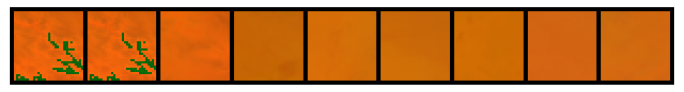

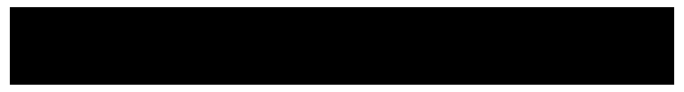

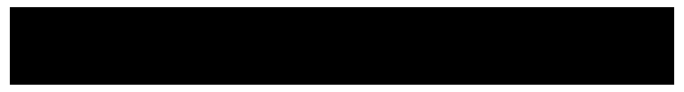

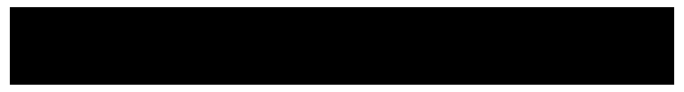

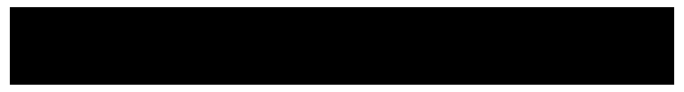

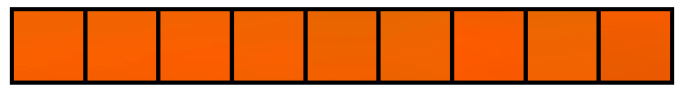

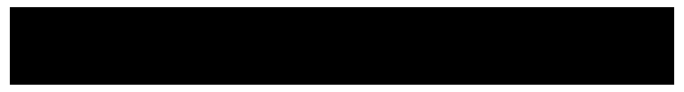

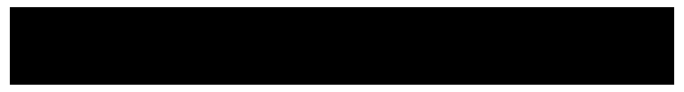

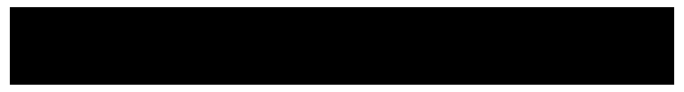

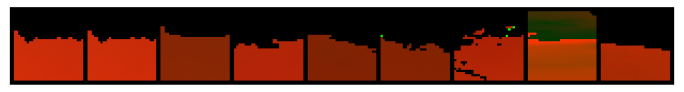

In [57]:
# Plot the closest images for the first N test images as example
for i in range(10):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds=test_img_embeds)

Nice!  For land based pixels we can see that the matching pixels are very similar to the query

Let's look at the training image embeddings using a TSNE Plot

In [47]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_img_embeds[1])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5467 samples in 0.002s...
[t-SNE] Computed neighbors for 5467 samples in 1.127s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5467
[t-SNE] Computed conditional probabilities for sample 2000 / 5467
[t-SNE] Computed conditional probabilities for sample 3000 / 5467
[t-SNE] Computed conditional probabilities for sample 4000 / 5467
[t-SNE] Computed conditional probabilities for sample 5000 / 5467
[t-SNE] Computed conditional probabilities for sample 5467 / 5467
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.022633
[t-SNE] KL divergence after 1000 iterations: 0.476604


<ipython-input-48-552219e0de18>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], cmap='viridis')


Text(0, 0.5, 't-SNE 2')

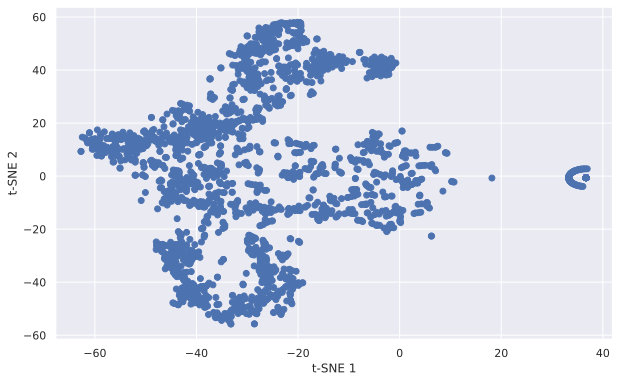

In [48]:
# Plot the TSNE results without label
plt.figure(figsize=(10, 6))
plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], cmap='viridis')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

Now let's add the future climate data (images) to see how they compare.  These are from the GFDL model from CMIP6 SSP3.7

In [49]:
zip_ref2 = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/gfdl_chips.zip", 'r')
zip_ref2.extractall("/tmp")
zip_ref2.close()

paths2 = '/tmp/gfdl_chips'
image_paths2 = glob.glob(paths2 + '/*.png')

dataset2 = MyDataset(image_paths2)

train_dataset2, test_dataset2, valid_dataset2 = torch.utils.data.random_split(dataset2, [0.7, 0.15, 0.15])

batch_size=256
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
val_loader2 = DataLoader(valid_dataset2, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)

def get_train_images2(num):
    return torch.stack([train_dataset2[i][0] for i in range(num)], dim=0)


def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    for imgs, _ in tqdm(data_loader, desc="Encoding images", leave=False):
        with torch.no_grad():
            z = model.encoder(imgs.to(model.device))
        img_list.append(imgs)
        embed_list.append(z)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))

train_img_embeds2 = embed_imgs(model, train_loader2)
test_img_embeds2 = embed_imgs(model, test_loader2)
val_img_embeds2 = embed_imgs(model,val_loader2)


Encoding images:   0%|          | 0/99 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/22 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/22 [00:00<?, ?it/s]

In [54]:
tsne = TSNE(2, verbose=1)
tsne_proj3 = tsne.fit_transform(test_img_embeds2[1])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5467 samples in 0.002s...
[t-SNE] Computed neighbors for 5467 samples in 0.943s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5467
[t-SNE] Computed conditional probabilities for sample 2000 / 5467
[t-SNE] Computed conditional probabilities for sample 3000 / 5467
[t-SNE] Computed conditional probabilities for sample 4000 / 5467
[t-SNE] Computed conditional probabilities for sample 5000 / 5467
[t-SNE] Computed conditional probabilities for sample 5467 / 5467
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.924095
[t-SNE] KL divergence after 1000 iterations: 0.454508


Text(0, 0.5, 't-SNE 2')

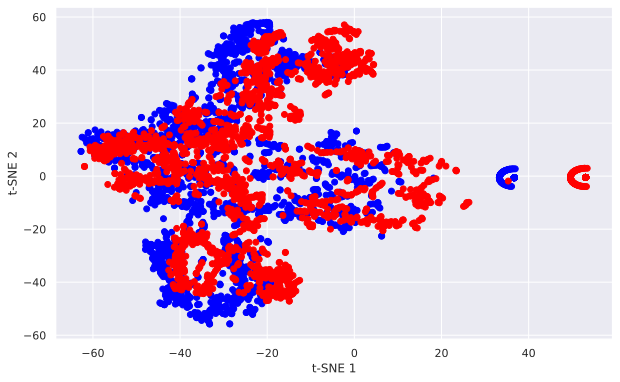

In [55]:
plt.figure(figsize=(10, 6))
plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], color="blue")
plt.scatter(tsne_proj3[:, 0], tsne_proj3[:, 1], color="red")
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')